#### Off by one error in to_sequences
Last week I fixed two minor looking off by one errors in my `to_sequences`  func.
I oringinally borrowed this func from  https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class10_lstm.ipynb
, and I modified it for my use case, but I may have introduced a copy error.

I had been using as the label of a sequence the y value of the element after the  sequence insteada of the last element of the sequence. Given the nature of continuous data, this might not make a difference, but I changed this just in case.

#### Different data
Since also in the previous week I started questioning whether the `'r', 'ecg', 'gsr'` features had good signal, (and although I think I had accidentally combined data for two `seats` in the post analysis, I think I should still look at the rest of the features anyhow). 

#### Different window sizes
Up until now I had been using a window size of `256`, which has been blowing up my memory whenenever I tried this, so now out of curiosity I want to try `64` or `128`.

#### Scaling
I think earlier, I did not use the other features because I was having weird outputs from scaling. Maybe I can revisit this again.

#### Possibly a more online approach to learning?
Since this data is super huge (especially when sequencifying it), I wonder if it is possible
to try learning in chunks. As far as I understand, multiple calls to `fit` in keras are perfectly fine and tensorflow style weight updates are done in a for loop anyway. I just need to improve the data feeding logistics..

In [15]:
from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools

import datetime
from collections import Counter



import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler

import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


In [16]:
# I had 
crew1df = pd.read_pickle('data/crew_1-train.pkl')
crew2df = pd.read_pickle('data/crew_2-train.pkl')

df1to2 = pd.concat([crew1df, crew2df])

cols = ['r', 'ecg', 'gsr', 'eeg_fp1','eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', ]


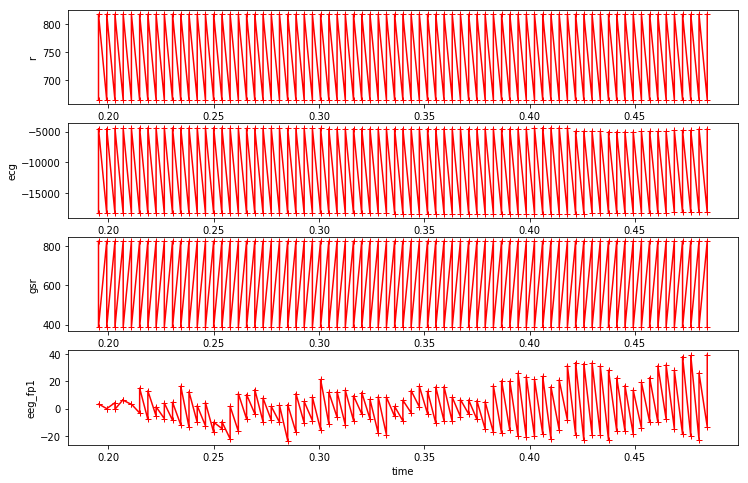

In [18]:
mp.produce_plots_for_col(
    crew1df, ['r', 'ecg', 'gsr', 'eeg_fp1',], range(50, 200)
)

In [19]:
crew1df.iloc[50:60][['time','crew', 'seat', 'event', 'ecg']]

,time,crew,seat,event,ecg
144,0.378906,1,0,A,-18278.90039
146,0.382812,1,0,A,-18278.90039
148,0.386719,1,0,A,-18278.90039
150,0.390625,1,0,A,-18278.90039
152,0.394531,1,0,A,-18278.90039
154,0.398438,1,0,A,-18278.90039
156,0.402344,1,0,A,-18278.90039
158,0.406250,1,0,A,-18278.90039
160,0.410156,1,0,A,-18278.90039
162,0.414062,1,0,A,-18278.90039


In [20]:
print(crew1df.shape)
crew1df.index = list(range(crew1df.shape[0]))

(447652, 28)


In [21]:
crew1df.iloc[:10][['time','crew', 'seat', 'event', 'ecg']]

,time,crew,seat,event,ecg
0,0.183594,1,0,A,-18260.80078
1,0.187500,1,0,A,-18260.80078
2,0.191406,1,0,A,-18260.80078
3,0.195312,1,0,A,-18260.80078
4,0.199219,1,0,A,-18260.80078
5,0.203125,1,0,A,-18260.80078
6,0.207031,1,0,A,-18260.80078
7,0.210938,1,0,A,-18260.80078
8,0.214844,1,0,A,-18261.69922
9,0.218750,1,0,A,-18261.69922


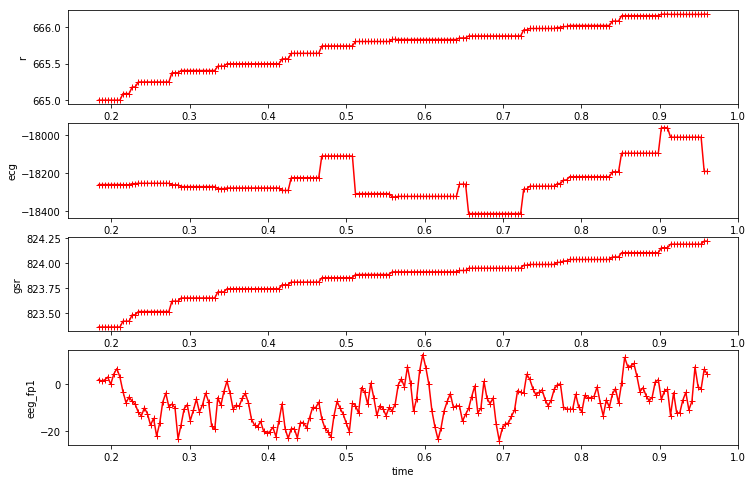

In [22]:
mp.produce_plots_for_col(
    crew1df, ['r', 'ecg', 'gsr', 'eeg_fp1',], range(0, 200)
)

In [23]:
print(crew1df.shape)
crew2df.index = list(range(crew2df.shape[0]))

(447652, 28)


In [24]:
df1to2 = pd.concat([crew1df, crew2df])

In [25]:
crew1df.shape , crew2df.shape, df1to2.shape

((447652, 28), (552868, 28), (1000520, 28))

In [26]:
mu.make_data?

In [34]:
!pip install ipdb

  Running setup.py bdist_wheel for ipdb ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7a/00/07/c906eaf1b90367fbb81bd840e56bf8859dbd3efe3838c0b4ba
Successfully built ipdb
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:

reload(mu)

<module 'mytf.utils' from '/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py'>

In [43]:
%%time
with ipdb.launch_ipdb_on_exception():
    out = mu.make_data(df1to2, crews={'training': [1],
                        'test': [2]},
                  window_size=64,
                   row_batch_size=10000,
             feature_cols=cols,
                  save_dir='data')

Start building training set 2019-11-04T003043Z
num slices 44
size_remainder,  7652
Start building testing set 2019-11-04T003119Z
num slices 55
size_remainder,  2868
CPU times: user 1min 9s, sys: 9.73 s, total: 1min 19s
Wall time: 1min 19s


In [47]:
with h5py.File('data/test.h5', 'r+') as fd:
    print(list(fd.keys()))


['dataset_0_X', 'dataset_0_Y', 'dataset_10_X', 'dataset_10_Y', 'dataset_11_X', 'dataset_11_Y', 'dataset_12_X', 'dataset_12_Y', 'dataset_13_X', 'dataset_13_Y', 'dataset_14_X', 'dataset_14_Y', 'dataset_15_X', 'dataset_15_Y', 'dataset_16_X', 'dataset_16_Y', 'dataset_17_X', 'dataset_17_Y', 'dataset_18_X', 'dataset_18_Y', 'dataset_19_X', 'dataset_19_Y', 'dataset_1_X', 'dataset_1_Y', 'dataset_20_X', 'dataset_20_Y', 'dataset_21_X', 'dataset_21_Y', 'dataset_22_X', 'dataset_22_Y', 'dataset_23_X', 'dataset_23_Y', 'dataset_24_X', 'dataset_24_Y', 'dataset_25_X', 'dataset_25_Y', 'dataset_26_X', 'dataset_26_Y', 'dataset_27_X', 'dataset_27_Y', 'dataset_28_X', 'dataset_28_Y', 'dataset_29_X', 'dataset_29_Y', 'dataset_2_X', 'dataset_2_Y', 'dataset_30_X', 'dataset_30_Y', 'dataset_31_X', 'dataset_31_Y', 'dataset_32_X', 'dataset_32_Y', 'dataset_33_X', 'dataset_33_Y', 'dataset_34_X', 'dataset_34_Y', 'dataset_35_X', 'dataset_35_Y', 'dataset_36_X', 'dataset_36_Y', 'dataset_37_X', 'dataset_37_Y', 'dataset_38_X

In [57]:
with h5py.File('data/test.h5', 'r+') as fd:
    X1 = fd['dataset_0_X'].__array__()
    Y1 = fd['dataset_0_Y'].__array__()

In [65]:
Y1[:10]

Counter([np.argmax(Y1[i]) for i in range(Y1.shape[0])]
)

Counter({0: 117, 2: 9819})

In [54]:
Y1.file

RuntimeError: Can't retrieve file id (invalid object ID)

In [31]:
!top

OSError: [Errno 12] Cannot allocate memory